In [66]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import statistics as st

def get_df(day):
    file_name = f"./round_3_data/prices_round_3_day_{day}.csv"
    return pd.read_csv(file_name, sep=';')

def get_product(df, product):
    return df[df['product'] == product].copy()

def get_first_two_dfs():
    zero_df = get_df(0)
    first_df = get_df(1)
    second_df = get_df(2)
    second_df['timestamp'] = second_df['timestamp'] + 2000000
    first_df['timestamp'] = first_df['timestamp'] + 1000000
    return pd.concat([zero_df, first_df, second_df])



In [67]:
df = get_first_two_dfs()

In [201]:

df_coconut = get_product(df, 'VOLCANIC_ROCK')
df_coconut_call = get_product(df, "VOLCANIC_ROCK_VOUCHER_9750")
df_coconut_call = df_coconut_call.merge(df_coconut[['timestamp', 'mid_price']], on='timestamp', suffixes=('', '_coconut'))

In [200]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_coconut['timestamp'], y=df_coconut['mid_price'], name='Coconut Mid Price'))
fig.add_trace(go.Scatter(x=df_coconut_call['timestamp'], y=df_coconut_call['mid_price'], name='Coconut Call Mid Price', yaxis='y2'))
fig.update_layout(title='Coconut and Coconut Call Prices over Timestamp', yaxis=dict(title='Coconut Mid Price'), yaxis2=dict(title='Coconut Call Bid Price', overlaying='y', side='right'))
fig.show()


In [195]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    call_price = (spot * norm.cdf(d1) - strike * norm.cdf(d2))
    return call_price

def black_scholes_put(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    put_price = (strike * norm.cdf(-d2) - spot * norm.cdf(-d1))
    return put_price

def delta(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.cdf(d1)

def gamma(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1)/(spot * volatility * np.sqrt(time_to_expiry))

def vega(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1) * (spot * np.sqrt(time_to_expiry)) / 100

def implied_volatility(call_price, spot, strike, time_to_expiry):
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility)
        return estimated_price - call_price

    # Using Brent's method to find the root of the equation
    implied_vol = brentq(equation, 1e-10, 3.0, xtol=1e-10)( )
    return implied_vol

def realized_vol(df_coconut_call, window, step_size):
    df_coconut_call[f'log_return_{step_size}'] = np.log(df_coconut_call['mid_price_coconut'].to_numpy()/df_coconut_call['mid_price_coconut'].shift(step_size).to_numpy())
    dt = step_size / 250 / 10000 
    df_coconut_call[f'realized_vol_{step_size}'] = df_coconut_call[f'log_return_{step_size}'].rolling(window=window).apply(lambda x: np.mean(x[::step_size]**2) / dt)
    df_coconut_call[f'realized_vol_{step_size}'] = np.sqrt(df_coconut_call[f'realized_vol_{step_size}'].to_numpy())
    return df_coconut_call

def vanna(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return 1/100 * np.sqrt(time_to_expiry) * norm.pdf(d1) * (1- d1/(volatility * np.sqrt(time_to_expiry)))


In [218]:
spot_price = 10500        # Spot price of the underlying asset
strike_price = 10000      # Strike price of the option
call_price = 1000     # Market price of the call option
time_to_expiry = 1
cur_round = 3      # Time to expiry in years
initial_guess = 16
day_in_year = 252
df_coconut_call['time_to_expiry'] = 5/252
# df_coconut_call['rolling_vol'] = (df_coconut_call['mid_price_coconut'].rolling(window=100).std()/df_coconut_call['mid_price_coconut']) * np.sqrt(252)
# df_coconut_call['rolling_vol'] = df_coconut_call['rolling_vol'].fillna(0.0137*np.sqrt(252))
# df_coconut_call['BS_price'] = df_coconut_call.apply(lambda row: black_scholes_call(row['mid_price_coconut'], strike_price, row['time_to_expiry'], row['rolling_vol']), axis=1)
df_coconut_call['implied_vol'] = df_coconut_call.apply(lambda row: implied_volatility(row['mid_price'], row['mid_price_coconut'], strike_price, row['time_to_expiry']), axis=1)
df_coconut_call['delta'] = df_coconut_call.apply(lambda row: delta(row['mid_price_coconut'], strike_price, row['time_to_expiry'], row['implied_vol']), axis=1)
df_coconut_call['gamma'] = df_coconut_call.apply(lambda row: gamma(row['mid_price_coconut'], strike_price, row['time_to_expiry'], row['implied_vol']), axis=1)
df_coconut_call['vega'] = df_coconut_call.apply(lambda row: vega(row['mid_price_coconut'], strike_price, row['time_to_expiry'], row['implied_vol']), axis=1)

TypeError: 'float' object is not callable

In [182]:
a= black_scholes_call(10160, 10500, 5/252, 0.013938*np.sqrt(252))
print(a)

24.069771727801935


In [178]:
print(min(df_coconut_call['BS_price'].dropna()))

0.0


In [104]:
df_coconut_call['cash_delta'] = df_coconut_call['delta'].to_numpy() * df_coconut_call['mid_price_coconut'].to_numpy()


In [210]:
fig = px.line(df_coconut_call, x='timestamp', y='BS_price', title='BS Price over Time')
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_coconut_call['timestamp'], y=df_coconut_call['BS_price'], name="BS_price"))
fig.add_trace(go.Scatter(x=df_coconut_call['timestamp'], y=df_coconut_call['mid_price'], name="Voucher Mid Price", yaxis="y2"))
fig.update_xaxes(title_text="Timestamp")
fig.update_layout(title_text="BS_price and Coconut Mid Price over Time")
fig.update_layout(yaxis2=dict(overlaying="y", side="right"))
fig.show()



In [209]:
fig = px.line(df_coconut_call, x='timestamp', y='BS_price', title='BS Price over Time')
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_coconut_call['timestamp'], y=df_coconut_call['BS_price'] - df_coconut_call['mid_price'], name="BS_price - Mid Price"))
fig.update_xaxes(title_text="Timestamp")
fig.update_layout(title_text="BS_price and Voucher Mid Price over Time")
fig.update_layout(yaxis2=dict(overlaying="y", side="right"))
fig.show()



In [105]:
import plotly.express as px

fig = px.line(df_coconut_call, x='timestamp', y='delta', title='Delta over Time')
fig.show()


In [106]:
fig = px.line(df_coconut_call, x='timestamp', y='gamma', title='Gamma over Time')
fig.show()

In [108]:
fig = px.line(df_coconut_call, x='timestamp', y='vega', title='Vega over Time')
fig.show()

In [114]:
fig = px.line(df_coconut_call, x='timestamp', y='implied_vol', title='Implied Volatility over Time')
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_coconut_call['timestamp'], y=df_coconut_call['implied_vol'], name="Implied Volatility"))
fig.add_trace(go.Scatter(x=df_coconut_call['timestamp'], y=df_coconut_call['mid_price_coconut'], name="Coconut Mid Price", yaxis="y2"))
fig.update_xaxes(title_text="Timestamp")
fig.update_layout(title_text="Implied Volatility and Coconut Mid Price over Time")
fig.update_layout(yaxis2=dict(overlaying="y", side="right"))
fig.show()



In [49]:
df_coconut_call['cash_gamma'] = df_coconut_call['gamma'].to_numpy() * df_coconut_call['mid_price_coconut'].to_numpy()
df_coconut_call['gamma_1pc'] = 0.01 * df_coconut_call['cash_gamma']
fig = px.line(df_coconut_call, x='timestamp', y='cash_gamma', title='Cash Gamma over Time')
fig.show()


In [115]:
df_coconut_call['vanna'] = df_coconut_call.apply(lambda row: vanna(row['mid_price_coconut'], strike_price, row['time_to_expiry'], row['implied_vol']), axis=1)
fig = px.line(df_coconut_call, x='timestamp', y='vanna', title='Vanna over Time')
fig.show()

In [116]:
implied_vol_mean = df_coconut_call['implied_vol'].mean()
print("Implied Volatility Mean: ", implied_vol_mean)
implied_vol_std = df_coconut_call['implied_vol'].std()
print("Implied Volatility Standard Deviation: ", implied_vol_std)
df_coconut_call['z_score'] = (df_coconut_call['implied_vol'] - implied_vol_mean) / implied_vol_std


Implied Volatility Mean:  0.8621818344338583
Implied Volatility Standard Deviation:  0.0845123235721419


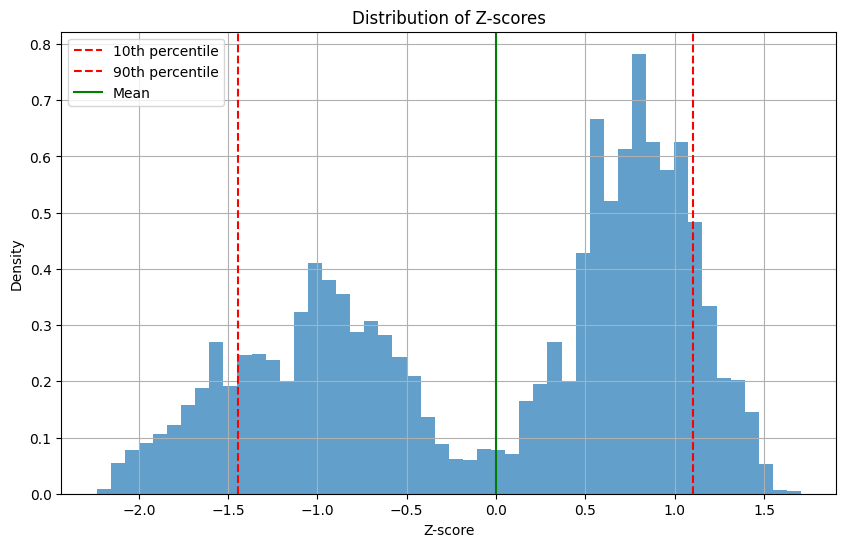

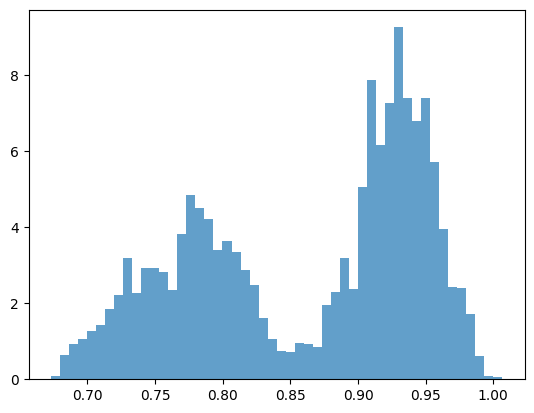

Percentage between 10th and 90th percentiles: 80.10%
10th percentile: -1.45
90th percentile: 1.10
Mean z-score: 0.00
Standard deviation of z-scores: 1.00
Skewness: -0.40
Kurtosis: -1.26


In [117]:
import pandas as pd
import numpy as np
from typing import Union, List
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy import stats

def analyze_zscore_distribution(df: pd.DataFrame) -> dict:
    """
    Analyze the distribution of z-scores and calculate what percentage falls between 10th and 90th percentiles
    """
    
    # Calculate percentiles
    p10 = df['z_score'].quantile(0.1)
    p90 = df['z_score'].quantile(0.9)
    
    # Calculate percentage between percentiles
    between_percentiles = df[(df['z_score'] >= p10) & (df['z_score'] <= p90)]
    percentage_between = (len(between_percentiles) / len(df)) * 100
    
    # Calculate additional statistics
    mean_z = df['z_score'].mean()
    std_z = df['z_score'].std()
    skewness = df['z_score'].skew()
    kurtosis = df['z_score'].kurtosis()
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['z_score'], bins=50, density=True, alpha=0.7)
    plt.axvline(x=p10, color='red', linestyle='--', label='10th percentile')
    plt.axvline(x=p90, color='red', linestyle='--', label='90th percentile')
    plt.axvline(x=mean_z, color='green', linestyle='-', label='Mean')
    plt.title('Distribution of Z-scores')
    plt.xlabel('Z-score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.hist(df['implied_vol'], bins=50, density=True, alpha=0.7)
    plt.show()
    
    return {
        'percentage_between_10_90': percentage_between,
        '10th_percentile': p10,
        '90th_percentile': p90,
        'mean_z': mean_z,
        'std_z': std_z,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'total_observations': len(df)
    }

results = analyze_zscore_distribution(df_coconut_call)
print(f"Percentage between 10th and 90th percentiles: {results['percentage_between_10_90']:.2f}%")
print(f"10th percentile: {results['10th_percentile']:.2f}")
print(f"90th percentile: {results['90th_percentile']:.2f}")
print(f"Mean z-score: {results['mean_z']:.2f}")
print(f"Standard deviation of z-scores: {results['std_z']:.2f}")
print(f"Skewness: {results['skewness']:.2f}")
print(f"Kurtosis: {results['kurtosis']:.2f}")

In [118]:
cash = 0
futures = 0
call = 0
size = 400
pnl = []
thresh = implied_vol_std
for index, row in df_coconut_call.iterrows():
    # Your code here
    implied_vol = row['implied_vol']
    call_price = row['mid_price']
    future_price = row['mid_price_coconut']
    delta = row['delta']
    if implied_vol > implied_vol_mean + implied_vol_std:
        cash = cash - (-size -  call) * call_price
        cash = cash - (size * delta - futures) * future_price
        call = -size
        futures = size * delta
    elif implied_vol < implied_vol_mean - implied_vol_std:
        cash = cash - (size -  call) * call_price
        cash = cash - (-size * delta - futures) * future_price
        call = size
        futures = -size * delta
    
    pnl.append(cash + call * call_price + futures * future_price)
        

In [83]:
cash = 0
futures = 0
call = 0
size = 400
pnl = []
thresh = implied_vol_std
target_gamma = 0.00005  # Target gamma level to maintain

for index, row in df_coconut_call.iterrows():
    # Your code here
    implied_vol = row['implied_vol']
    call_price = row['mid_price']
    future_price = row['mid_price_coconut']
    delta = row['delta']
    gamma = row['gamma']
    
    # Calculate current portfolio gamma
    portfolio_gamma = call * gamma
    
    if implied_vol > implied_vol_mean + implied_vol_std:
        # Adjust size based on gamma
        gamma_adjusted_size = size * (target_gamma / abs(gamma)) if gamma != 0 else size
        cash = cash - (-gamma_adjusted_size - call) * call_price
        cash = cash - (gamma_adjusted_size * delta - futures) * future_price
        call = -gamma_adjusted_size
        futures = gamma_adjusted_size * delta
    elif implied_vol < implied_vol_mean - implied_vol_std:
        # Adjust size based on gamma
        gamma_adjusted_size = size * (target_gamma / abs(gamma)) if gamma != 0 else size
        cash = cash - (gamma_adjusted_size - call) * call_price
        cash = cash - (-gamma_adjusted_size * delta - futures) * future_price
        call = gamma_adjusted_size
        futures = -gamma_adjusted_size * delta
    
    pnl.append(cash + call * call_price + futures * future_price)

In [119]:
fig = px.line(x=df_coconut_call['timestamp'], y=pnl, title='PnL over Time')
fig.show()


In [307]:
df_trades = get_trades_df(1)
df_trades_coupon = df_trades[df_trades['symbol'] == 'COCONUT_COUPON']
df_trades_coupon['quantity'] = df_trades_coupon['quantity'].astype(int)
df_trades_coupon = df_trades_coupon.groupby('timestamp')['quantity'].sum().reset_index()
fig = px.histogram(df_trades_coupon, x='quantity', title='Traded Volume over Time')
fig.show()
df_trades_coupon[df_trades_coupon['quantity'] > 25]



/var/folders/9b/84mpgsld28b38s8hfxg9c3rm0000gn/T/ipykernel_8547/1281816314.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



timestamp  quantity
24       26600        27
43       44600        32
77       74800        28
107     101500        29
124     124800        31
156     166800        27
166     174900        30
310     319400        33
340     352800        35
394     409600        32
438     452200        40
447     462200        30
464     476600        30
504     537500        29
566     617600        38
592     644300        30
651     718300        31
718     780500        35
737     803400        30
798     870900        27
812     889000        28
848     923900        28
854     936400        28
865     946200        28
915     992400        33